## A.1: Replication of Baseline Results

### A.1.1 Setup

This .ipynb file reproduces the RGB U-Net and Attention U-Net results from Table 5 of David and Zhang (2022)'s paper "An attention-based U-Net for detecting deforestation within satellite sensor imagery". The associated github repository is accessible here: https://github.com/davej23/attention-mechanism-unet/tree/main.

To reproduce these results using the following code, the Amazon RGB dataset should be downloaded at this repository (https://zenodo.org/records/3233081) and the .rar file placed into a folder named 'Data1' at the same level as this ipynb file. I have removed all comments from the original authors to make clearer any adjustments I have made to the code or dependencies to allow it to run.

Please Note: This notebook was run using AWS SageMarker (instance type: ml.g4dn.xlarge) on an NVIDIA T4 Tensor Core GPU with 16 GB of VRAM. 

In [1]:
# As suggested by authors, for greater numerical reproducibility oneDNN optimisation is disabled
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
print("oneDNN optimizations disabled.")

# Cloning github repo
!git clone https://github.com/davej23/attention-mechanism-unet.git

%cd attention-mechanism-unet
print("Current working directory successfully reset.")

# Fixing some compatibility issues with requirements.txt
!sed -i 's/PIL/Pillow/g' requirements.txt
!sed -i 's/sklearn/scikit-learn/g' requirements.txt

# Now installing requirements
!pip install -r requirements.txt
print("\nPython dependencies satisfied.")

!pip install keras-segmentation

# Fixing issue with unrar installation from requirements.txt
!conda install unrar -c conda-forge -y

# Fixing issue with requirements.txt regarding h5py installation
!conda install h5py rarfile patool -c conda-forge -y
print("\nConda dependencies (h5py, rarfile, patool) fixed.")

oneDNN optimizations disabled.
fatal: destination path 'attention-mechanism-unet' already exists and is not an empty directory.
/home/ec2-user/SageMaker/attention-mechanism-unet
Current working directory successfully reset.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 180.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 179.5 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 154.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [rioxarray]17 [xarray]o]

Python dependencies satisfied.
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 124.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.3/753.3 kB 54.2 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 123.1 MB/s  0:00:00
  DEPRECATION: Building 'keras-segmentation' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour

In [2]:
!pip uninstall keras-segmentation -y
#Removing old keras-segmentation due to dependency issues

Found existing installation: keras_segmentation 0.3.0
Uninstalling keras_segmentation-0.3.0:
  Successfully uninstalled keras_segmentation-0.3.0


In [3]:
!pip install git+https://github.com/davej23/image-segmentation-keras.git --no-deps
#installing image-segmentation-keras with no dependencies 

  Cloning https://github.com/davej23/image-segmentation-keras.git to /tmp/pip-req-build-q9v7uzwu
  Running command git clone --filter=blob:none --quiet https://github.com/davej23/image-segmentation-keras.git /tmp/pip-req-build-q9v7uzwu
  Resolved https://github.com/davej23/image-segmentation-keras.git to commit e01b0a8d5859854cd9d259a618829889166439f5
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'keras_segmentation' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'keras_segmentation'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for keras_segmentation: filename=keras_segmentation-0.3.0-py3-none-any.whl size=34444 sha256=350802fc0d03c688

In [4]:
# Fixing issue with segmentation-models compatibility
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'
print("SM_FRAMEWORK set to tf.keras.")

# Documenting dependencies and imports
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose, Activation, add, multiply, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam as KerasAdam 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K
from sklearn.metrics import accuracy_score, recall_score, precision_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

import os
import PIL
import pathlib
import sys
from rarfile import RarFile 
import segmentation_models as sm 
from keras_segmentation.models import segnet 
from keras.applications import vgg16
import rioxarray as rxr

print("\nAll imports successful")

SM_FRAMEWORK set to tf.keras.


2025-12-09 14:01:41.749956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-12-09 14:01:45.892486: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-12-09 14:01:45.940913: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-12-09 14:01:52.167066: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-09 14:02:01.618530: W te

KeyboardInterrupt: 

### Defining Functions
Replicating function definitions from Experimentation.ipynb file in the original repository.

In [ ]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  reconstruction = reconstruction/np.max(reconstruction)

  if rounded:
    reconstruction = np.round(reconstruction)

  plt.imshow(reconstruction) 
     

In [ ]:
def reconstruct_array(model, image, rounded=False):
    reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

    if rounded:
        reconstruction = np.round(reconstruction)

    return reconstruction 

In [ ]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): 
    if type(image) != list:
        reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
        reconstruction = np.round(reconstruction).flatten()

        return accuracy_score(mask.flatten(), reconstruction)

    else: 
        scores = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
            reconstruction = np.round(reconstruction).flatten()

            scores.append(accuracy_score(mask[i].flatten(), reconstruction))

        return scores

def score_eval2(model, image, mask): 
    if type(image) != list:
        reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
        reconstruction = np.round(reconstruction).flatten()

        return accuracy_score(mask.flatten(), reconstruction)

    else: 
        scores = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
            reconstruction = np.round(reconstruction).flatten()

            scores.append(accuracy_score(mask[i].flatten(), reconstruction))

        return scores

def recall_eval(model, image, mask): 
    if type(image) != list:
        reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
        reconstruction = np.round(reconstruction).flatten()

        return recall_score(mask.flatten(), reconstruction, average='weighted')

    else: 
        recall = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
            reconstruction = np.round(reconstruction).flatten()

            recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

        return recall

def precision_eval(model, image, mask): 
    if type(image) != list:
        reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
        reconstruction = np.round(reconstruction).flatten()

        return precision_score(mask.flatten(), reconstruction, average='weighted')

    else: 
        precision = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
            reconstruction = np.round(reconstruction).flatten()

            precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

        return precision

def f1_score_eval(model, image, mask): 
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): 
    return np.round(image)

### Model Definition

#### U-Net

In [ ]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
        conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    else:
    #conv = ZeroPadding2D((1,1))(input)
        conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

    conv = Activation(act)(conv)
    return conv
    
'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    inputs = Input(input_size, batch_size=1)

    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    # **Adjustment here to use the imported alias KerasAdam, maintaining consistency with imports**
    model.compile(optimizer = KerasAdam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
        model.load_weights(trained_weights)

    return model

#### Attention U-Net

In [ ]:
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input, Conv2D, Activation, MaxPooling2D, Conv2DTranspose, concatenate, add, UpSampling2D, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam as KerasAdam
import tensorflow as tf

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    else:
        conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    return conv

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
    if transpose == False:
        conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
        conv = Activation(act)(conv)
        conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
        conv = Activation(act)(conv)
    else:
        conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
        conv = Activation(act)(conv)
        conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
        conv = Activation(act)(conv)
    return conv
    
'''
  Attention block/mechanism - FINAL CORRECTION
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):
    
    shape_x = K.int_shape(x)

    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)

    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)

    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    upsample_psi = UpSampling2D(interpolation='bilinear', size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)
    
    batch_size = tf.shape(x)[0]
    
    target_shape = [batch_size, shape_x[1], shape_x[2], shape_x[3]]
    
    upsample_psi = tf.broadcast_to(upsample_psi, shape=target_shape)

    y = multiply([upsample_psi, x])
    return y

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):
    # **Fixed batch size was causing issues in validation; fixed by removing batch_size=1** CRITICAL FIX: REMOVE batch_size=1
    inputs = Input(input_size) 
    
    
    conv = convBlock2(inputs, filter_base, 3)
    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)

    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate)
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate)
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate)
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate)
    conv7 = concatenate([up7, merge7])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)
    model.compile(optimizer = KerasAdam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])
 # **Adjustment here to use the imported alias KerasAdam, maintaining consistency with imports**
    if trained_weights != None:
        model.load_weights(trained_weights)

    return model
    

# RGB Dataset

In [13]:
UNRAR_COMMAND = "unrar" 
DATA_PATH = "/home/ec2-user/SageMaker/Data1" 

!cp -r "{DATA_PATH}/Amazon Forest Dataset.rar" dataset/

%cd dataset

# Extracting
!"{UNRAR_COMMAND}" x -o- "Amazon Forest Dataset.rar"

%cd ..

/home/ec2-user/SageMaker/attention-mechanism-unet/dataset

UNRAR 7.20 beta 2 freeware      Copyright (c) 1993-2025 Alexander Roshal

Extracting from Amazon Forest Dataset.rar

Creating    Amazon Forest Dataset                                     OK
Creating    Amazon Forest Dataset/Test                                OK
Extracting  Amazon Forest Dataset/Test/0.tiff                            1  OK 
Extracting  Amazon Forest Dataset/Test/1.tiff                            2  OK 
Extracting  Amazon Forest Dataset/Test/10.tiff                           4  OK 
Extracting  Amazon Forest Dataset/Test/11.tiff                           5  OK 
Extracting  Amazon Forest Dataset/Test/12.tiff                           7  OK 
Extracting  Amazon Forest Dataset/Test/13.tiff                           9  OK 
Extracting  Amazon Forest Dataset/Test/14.tiff                          10  OK 
Extracting  Amazon Forest Dataset/Test/2.tiff                           12  OK 
Extracting  Amazon Forest Dataset/Test

In [14]:
# Updating path
!sed -i 's/\.\/Amazon Forest Dataset\//.\/dataset\/Amazon Forest Dataset\//g' preprocess-rgb-data.py

## U-Net 3 Band Amazon Reproduction

In [33]:
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.optimizers import Adam as KerasAdam 

base_dir = r"dataset/Amazon Forest Dataset/"

# Ingesting images, combined from Experimentation.ipynb logic
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
    im = PIL.Image.open(r"{}Training/images/{}".format(base_dir, n))
    training_images.append(im)
    training_masks_list.append(n[:-5] + '.png')

training_masks = []
for n in training_masks_list:
    im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir, n))
    training_masks.append(im)

# Validation Images and Test Images 
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
test_images_list = validation_images_list 
validation_masks_list = []
validation_images = []
test_images = []
for n in validation_images_list:
    im_v = PIL.Image.open(r"{}Validation/images/{}".format(base_dir, n))
    validation_images.append(im_v)
    validation_masks_list.append(n[:-5] + '.png')

    test_images.append(im_v) 

validation_masks = []
for n in validation_masks_list:
    im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir, n))
    validation_masks.append(im)


# Implementing pre-processing here in combination

# Training Images/Masks 
for i in range(len(training_images)):
    training_images[i] = np.array(training_images[i]) / 255
    training_images[i] = training_images[i].reshape(512, 512, 3)
    training_images[i] = training_images[i].astype('float32')
for i in range(len(training_masks)):
    training_masks[i] = (np.array(training_masks[i]) - 1)
    training_masks[i] = training_masks[i][:512, :512]
    training_masks[i] = training_masks[i].reshape(512, 512, 1)
    training_masks[i] = training_masks[i].astype('int')

# Validation Images/Masks 
for i in range(len(validation_images)):
    validation_images[i] = np.array(validation_images[i]) / 255
    validation_images[i] = validation_images[i].reshape(1, 512, 512, 3)
    validation_images[i] = validation_images[i].astype('float32')
for i in range(len(validation_masks)):
    validation_masks[i] = np.array(validation_masks[i]) - 1
    validation_masks[i] = validation_masks[i][:512, :512]
    validation_masks[i] = validation_masks[i].reshape(1, 512, 512, 1)
    validation_masks[i] = validation_masks[i].astype('int')

# Test Images
for i in range(len(test_images)):
    test_images[i] = np.array(test_images[i]) / 255
    test_images[i] = test_images[i].reshape(1, 512, 512, 3)
    test_images[i] = test_images[i].astype('float32')

try:
    for i in range(25, 30):
        validation_images.append(training_images[i].reshape(1, 512, 512, 3))
        validation_masks.append(training_masks[i].reshape(1, 512, 512, 1))
except IndexError:
    print("\n⚠️ Warning: Could not augment validation set. The training set likely contains fewer than 30 images. Training set size: " + str(len(training_images)))
    
training_images = training_images[0:25]
training_masks = training_masks[0:25]


# Defining generator functions
def adjustData(img, mask, num_class):
    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST
    return (img, mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512, 512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed) 

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)
    
    train_generator = zip(image_generator, mask_generator)
    
    for (img,mask) in train_generator: 
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

# Final arrays
t_images = np.stack(training_images)
t_masks = np.stack(training_masks)
v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

# Data augmentation arguments, matching notebook parameters
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
validation_df = tf.data.Dataset.from_tensor_slices((v_images, v_masks))

print("\nData loading, preprocessing, and generator definitions complete.")

# Running training block now
print("Starting U-Net training...")

model_unet = UNet(input_size=(512,512,3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.hdf5', monitor='val_accuracy',verbose=1, save_best_only=True)

model_unet.fit(train, steps_per_epoch=100, epochs=30, validation_data = validation_df, callbacks=[save_model])


Data loading, preprocessing, and generator definitions complete.
Starting U-Net training...
Epoch 1/30


2025-12-09 11:50:47.676966: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1765281067.076336   32448 service.cc:145] XLA service 0x7f4a4f840120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1765281067.076375   32448 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-12-09 11:51:07.257685: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1765281067.660061   32448 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


100/100 [==============================] - ETA: 0s - loss: 0.4765 - accuracy: 0.7324 - mse: 0.1594
Epoch 1: val_accuracy improved from -inf to 0.90667, saving model to unet-3d.hdf5


/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


100/100 [==============================] - 75s 292ms/step - loss: 0.4765 - accuracy: 0.7324 - mse: 0.1594 - val_loss: 0.2635 - val_accuracy: 0.9067 - val_mse: 0.0746
Epoch 2/30
100/100 [==============================] - ETA: 0s - loss: 0.2323 - accuracy: 0.9114 - mse: 0.0675
Epoch 2: val_accuracy did not improve from 0.90667
100/100 [==============================] - 22s 224ms/step - loss: 0.2323 - accuracy: 0.9114 - mse: 0.0675 - val_loss: 0.3444 - val_accuracy: 0.8816 - val_mse: 0.0943
Epoch 3/30
100/100 [==============================] - ETA: 0s - loss: 0.1703 - accuracy: 0.9392 - mse: 0.0471
Epoch 3: val_accuracy improved from 0.90667 to 0.91664, saving model to unet-3d.hdf5
100/100 [==============================] - 25s 248ms/step - loss: 0.1703 - accuracy: 0.9392 - mse: 0.0471 - val_loss: 0.2319 - val_accuracy: 0.9166 - val_mse: 0.0643
Epoch 4/30
100/100 [==============================] - ETA: 0s - loss: 0.1559 - accuracy: 0.9397 - mse: 0.0451
Epoch 4: val_accuracy improved from 

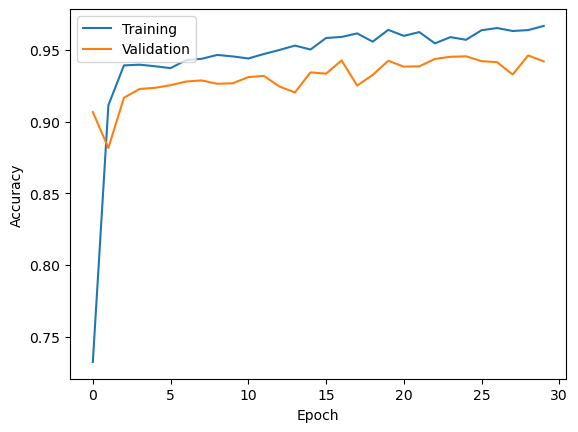

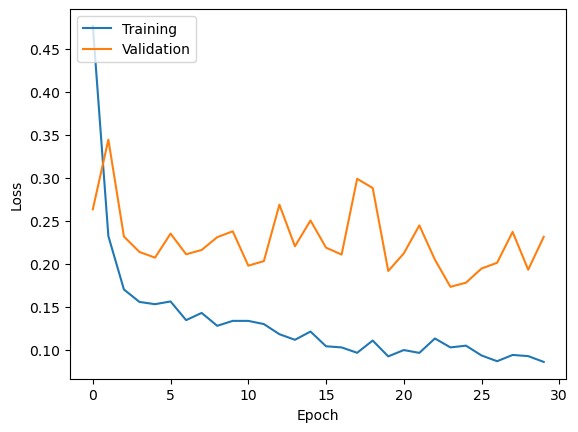

In [40]:
# Plot accuracy and loss as in original implementation
## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

In [45]:
# **Fix: Needed to apply squeezing to reshape v_images from (N, 1, 512, 512, 3) to (N, 512, 512, 3), as this was causing errors**
v_images_fixed = v_images.squeeze(axis=1)

# Same for v_masks
v_masks_fixed = v_masks.squeeze(axis=1)

print("Validation arrays reshaped to remove the extra dimension.")

Validation arrays reshaped to remove the extra dimension.


In [51]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, recall_score, precision_score
import numpy as np


#Defining IoU, which was not defined in Experimentation.ipynb
def iou_eval(model, image, mask):
    if type(image) != list:
        reconstruction = model.predict(image).flatten()
        reconstruction = np.round(reconstruction).astype(int) 
        
        mask_flat = mask.flatten().astype(int)

        intersection = np.sum(reconstruction & mask_flat)
        union = np.sum(reconstruction | mask_flat)
        
        # Handle case where union is zero (empty image/prediction)
        if union == 0:
            return 1.0 
        
        return intersection / union
        
    else: 
        iou_scores = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i].reshape(1, 512, 512, 3)).flatten().astype(int)
            reconstruction = np.round(reconstruction)
            mask_flat = mask[i].flatten().astype(int)

            intersection = np.sum(reconstruction & mask_flat)
            union = np.sum(reconstruction | mask_flat)
            
            iou_scores.append(intersection / union if union > 0 else 1.0)
        return iou_scores

# Redefining existing metric functions to avoid errors

def score_eval(model, image, mask):
    if type(image) != list:
        reconstruction = model.predict(image).flatten()
        reconstruction = np.round(reconstruction)
        return accuracy_score(mask.flatten(), reconstruction)
    else:
        scores = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i].reshape(1, 512, 512, 3)).flatten()
            reconstruction = np.round(reconstruction)
            scores.append(accuracy_score(mask[i].flatten(), reconstruction))
        return scores

def precision_eval(model, image, mask):
    if type(image) != list:
        reconstruction = model.predict(image).flatten()
        reconstruction = np.round(reconstruction)
        return precision_score(mask.flatten(), reconstruction, average='weighted', zero_division=0)
    else:
        precision = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i]).flatten()
            reconstruction = np.round(reconstruction)
            precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted', zero_division=0))
        return precision

def recall_eval(model, image, mask):
    if type(image) != list:
        reconstruction = model.predict(image).flatten()
        reconstruction = np.round(reconstruction)
        return recall_score(mask.flatten(), reconstruction, average='weighted', zero_division=0)
    else:
        recall = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i]).flatten()
            reconstruction = np.round(reconstruction)
            recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted', zero_division=0))
        return recall

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)
    if prec + rec == 0:
        return 0
    return 2 * (prec * rec) / (prec + rec)

# Loading best model
try:
    unet = load_model('unet-3d.hdf5', custom_objects={'KerasAdam': KerasAdam})
except NameError:
    unet = load_model('unet-3d.hdf5')

# **Needed to squeeze validation errors from 5D as model prediction expects 4D**
if v_images.ndim == 5:
    v_images_fixed = v_images.squeeze(axis=1)
    v_masks_fixed = v_masks.squeeze(axis=1)
else:
    v_images_fixed = v_images
    v_masks_fixed = v_masks


print("Calculating U-Net Evaluation Results...")
unet_score = score_eval(unet, v_images_fixed, v_masks_fixed)
unet_precision = precision_eval(unet, v_images_fixed, v_masks_fixed)
unet_recall = recall_eval(unet, v_images_fixed, v_masks_fixed)
unet_f1_score = f1_score_eval_basic(unet_precision, unet_recall)
unet_iou = iou_eval(unet, v_images_fixed, v_masks_fixed)

print("\n--- U-Net Evaluation Results ---")
print(f"Accuracy: {np.mean(unet_score):.4f}")
print(f"Precision: {np.mean(unet_precision):.4f}")
print(f"Recall: {np.mean(unet_recall):.4f}")
print(f"F1-Score: {unet_f1_score:.4f}")
print(f"IoU Score: {unet_iou:.4f}")

Calculating U-Net Evaluation Results...
1/1 [==============================] - 0s 83ms/step

--- U-Net Evaluation Results ---
Accuracy: 0.9461
Precision: 0.9475
Recall: 0.9461
F1-Score: 0.9468
IoU Score: 0.8870


## Attention U-Net 3-Band Amazon Reproduction

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Using learning rate from paper
model_unet_am = UNetAM(input_size=(512,512,3), lr=0.0005)

save_model_am = ModelCheckpoint('unet-am-3d.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True)

print("Starting Attention U-Net training (LR=0.0005, Epochs=50)...")

# 50 epochs as per paper
history_object_am = model_unet_am.fit(
    train, 
    steps_per_epoch=100, 
    epochs=50, 
    validation_data = validation_df, 
    callbacks=[save_model_am]
)

Starting Attention U-Net training (LR=0.0005, Epochs=50)...
Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.7507 - mse: 0.1582
Epoch 1: val_accuracy improved from -inf to 0.89959, saving model to unet-am-3d.hdf5
100/100 [==============================] - 23s 104ms/step - loss: 0.4826 - accuracy: 0.7507 - mse: 0.1582 - val_loss: 0.3081 - val_accuracy: 0.8996 - val_mse: 0.0887
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9195 - mse: 0.0618
Epoch 2: val_accuracy did not improve from 0.89959
100/100 [==============================] - 8s 76ms/step - loss: 0.2128 - accuracy: 0.9195 - mse: 0.0618 - val_loss: 0.3088 - val_accuracy: 0.8920 - val_mse: 0.0849
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.1775 - accuracy: 0.9362 - mse: 0.0492
Epoch 3: val_accuracy improved from 0.89959 to 0.90607, saving model to unet-am-3d.hdf5
100/100 [==============================] - 8s 79ms/step 

Attention U-Net training history saved.


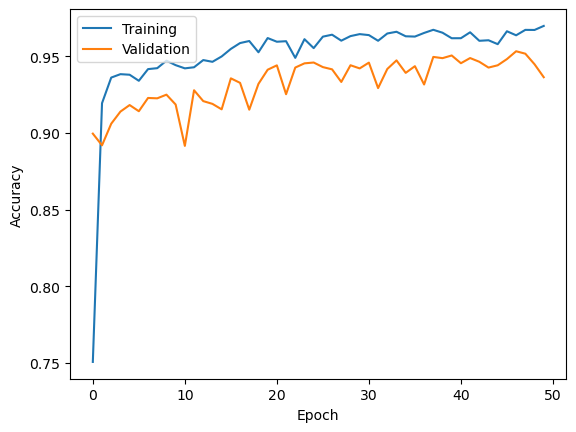

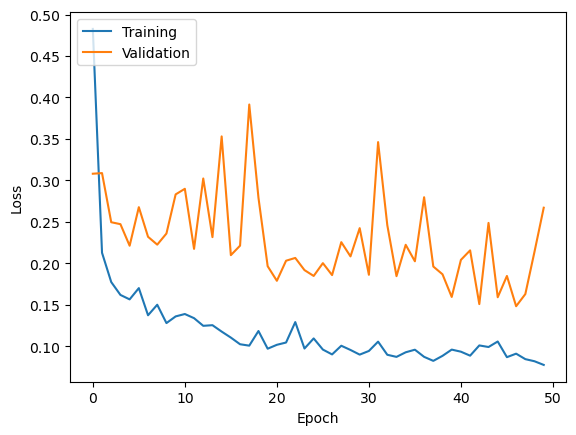

Attention U-Net model and history archived locally in models/.


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import os

np.save('unet-am-3d-history.npy', history_object_am.history)
print("Attention U-Net training history saved.")

plt.plot(history_object_am.history['accuracy'])
plt.plot(history_object_am.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(history_object_am.history['loss'])
plt.plot(history_object_am.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
#Archive locally
!mkdir -p models/ 
!cp unet-am-3d.hdf5 models/
!cp unet-am-3d-history.npy models/
print("Attention U-Net model and history archived locally in models/.")

In [33]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, recall_score, precision_score
import numpy as np


def iou_eval(model, image, mask):
    if type(image) != list:
        reconstruction = model.predict(image).flatten()
        reconstruction = np.round(reconstruction).astype(int)
        
        mask_flat = mask.flatten().astype(int)

        intersection = np.sum(reconstruction & mask_flat)
        union = np.sum(reconstruction | mask_flat)
        
        if union == 0:
            return 1.0 
        
        return intersection / union
        
    else: 
        iou_scores = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i].reshape(1, 512, 512, 3)).flatten().astype(int)
            reconstruction = np.round(reconstruction)
            mask_flat = mask[i].flatten().astype(int)

            intersection = np.sum(reconstruction & mask_flat)
            union = np.sum(reconstruction | mask_flat)
            
            iou_scores.append(intersection / union if union > 0 else 1.0)
        return iou_scores


def score_eval(model, image, mask):
    if type(image) != list:
        reconstruction = model.predict(image).flatten()
        reconstruction = np.round(reconstruction)
        return accuracy_score(mask.flatten(), reconstruction)
    else:
        scores = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i].reshape(1, 512, 512, 3)).flatten()
            reconstruction = np.round(reconstruction)
            scores.append(accuracy_score(mask[i].flatten(), reconstruction))
        return scores

def precision_eval(model, image, mask):
    if type(image) != list:
        reconstruction = model.predict(image).flatten()
        reconstruction = np.round(reconstruction)
        return precision_score(mask.flatten(), reconstruction, average='weighted', zero_division=0)
    else:
        precision = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i]).flatten()
            reconstruction = np.round(reconstruction)
            precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted', zero_division=0))
        return precision

def recall_eval(model, image, mask):
    if type(image) != list:
        reconstruction = model.predict(image).flatten()
        reconstruction = np.round(reconstruction)
        return recall_score(mask.flatten(), reconstruction, average='weighted', zero_division=0)
    else:
        recall = []
        for i in range(len(image)):
            reconstruction = model.predict(image[i]).flatten()
            reconstruction = np.round(reconstruction)
            recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted', zero_division=0))
        return recall

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)
    if prec + rec == 0:
        return 0
    return 2 * (prec * rec) / (prec + rec)

try:
    unet_am = load_model('unet-am-3d.hdf5', custom_objects={'KerasAdam': KerasAdam})
except NameError:
    unet_am = load_model('unet-am-3d.hdf5')

if v_images.ndim == 5:
    v_images_fixed = v_images.squeeze(axis=1)
    v_masks_fixed = v_masks.squeeze(axis=1)
else:
    v_images_fixed = v_images
    v_masks_fixed = v_masks


print("Calculating Attention U-Net Evaluation Results...")

unet_am_score = score_eval(unet_am, v_images_fixed, v_masks_fixed)
unet_am_precision = precision_eval(unet_am, v_images_fixed, v_masks_fixed)
unet_am_recall = recall_eval(unet_am, v_images_fixed, v_masks_fixed)
unet_am_f1_score = f1_score_eval_basic(unet_am_precision, unet_am_recall)
unet_am_iou = iou_eval(unet_am, v_images_fixed, v_masks_fixed) 

print("\n--- Attention U-Net Evaluation Results ---")
print(f"Accuracy: {np.mean(unet_am_score):.4f}")
print(f"Precision: {np.mean(unet_am_precision):.4f}")
print(f"Recall: {np.mean(unet_am_recall):.4f}")
print(f"F1-Score: {unet_am_f1_score:.4f}")
print(f"IoU Score: {unet_am_iou:.4f}")

Calculating Attention U-Net Evaluation Results...
1/1 [==============================] - 0s 85ms/step

--- Attention U-Net Evaluation Results ---
Accuracy: 0.9533
Precision: 0.9534
Recall: 0.9533
F1-Score: 0.9534
IoU Score: 0.9036
